<a href="https://colab.research.google.com/github/22Himanshu/AppliedMachineLearning/blob/main/Chicken_Duck_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
from zipfile import ZipFile

# GitHub raw URL (replace blob with raw)
url = "https://github.com/22Himanshu/AppliedMachineLearning/raw/main/Assignment5/Chicken_Duck_data.zip"

# Download the file
zip_path = "Chicken_Duck_data.zip"
print("Downloading dataset...")
r = requests.get(url)
with open(zip_path, "wb") as f:
    f.write(r.content)

# Unzip it
print("Extracting dataset...")
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("Chicken_Duck_data")

print("Done! Dataset ready.")


Extracting dataset...
Done! Dataset ready.


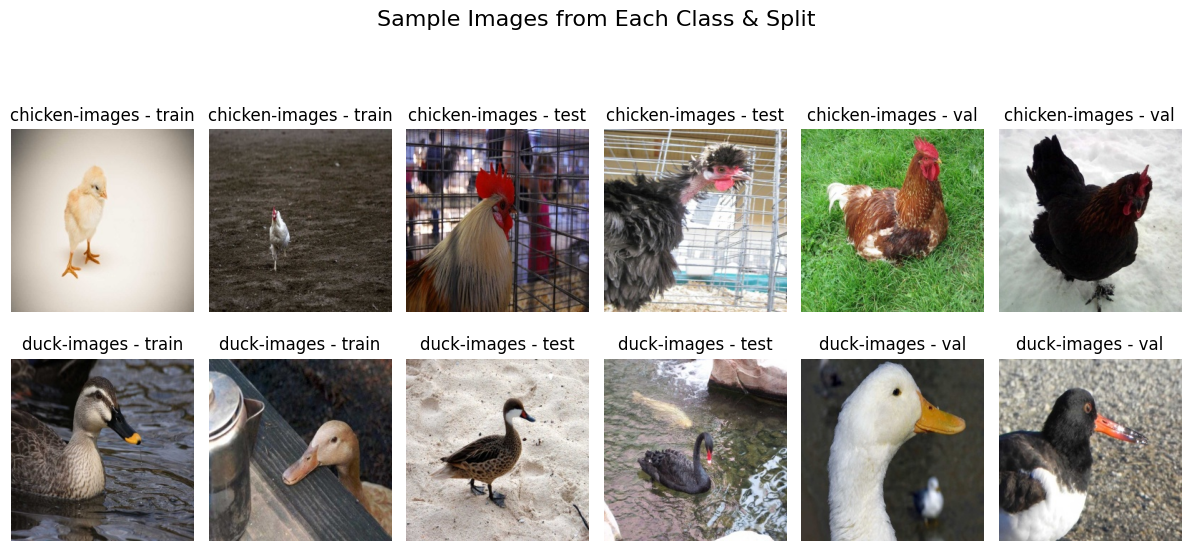

In [2]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Correct the base path to the actual dataset location
base_path = "Chicken_Duck_data/Chicken_Duck_data"

# Dataset types and categories
splits = ["train", "test", "val"]
classes = ["chicken-images", "duck-images"]

# Plot setup
fig, axes = plt.subplots(len(classes), len(splits)*2, figsize=(12, 6))
fig.suptitle("Sample Images from Each Class & Split", fontsize=16)

for row, cls in enumerate(classes):
    for col, split in enumerate(splits):
        folder = os.path.join(base_path, cls, split)

        # Check if the folder exists
        if not os.path.exists(folder):
            print(f"Missing folder: {folder}")
            continue

        # List all images in the folder
        images = os.listdir(folder)

        # Randomly pick 2 images
        selected_images = random.sample(images, 2)

        for i, img_file in enumerate(selected_images):
            img_path = os.path.join(folder, img_file)
            try:
                # Open the image
                img = Image.open(img_path)
                ax = axes[row, col*2 + i]
                ax.imshow(img)
                ax.set_title(f"{cls} - {split}")
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


In [3]:
import shutil

base_dir = "Chicken_Duck_data/Chicken_Duck_data"
output_dir = "Chicken_Duck_data/organized"

splits = ["train", "val", "test"]
classes = {"chicken-images": "chicken", "duck-images": "duck"}

for split in splits:
    for original_class, new_class in classes.items():
        src_dir = os.path.join(base_dir, original_class, split)
        dst_dir = os.path.join(output_dir, split, new_class)
        os.makedirs(dst_dir, exist_ok=True)

        for filename in os.listdir(src_dir):
            src_file = os.path.join(src_dir, filename)
            dst_file = os.path.join(dst_dir, filename)
            shutil.copy2(src_file, dst_file)

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize images to 224x224
    transforms.ToTensor(),              # Convert images to tensor
    transforms.Normalize(               # Normalize images with ResNet's mean and std
        mean=[0.485, 0.456, 0.406],     # ResNet mean
        std=[0.229, 0.224, 0.225]       # ResNet std
    )
])


train_dataset = datasets.ImageFolder(root='Chicken_Duck_data/organized/train', transform=transform)
val_dataset = datasets.ImageFolder(root='Chicken_Duck_data/organized/val', transform=transform)
test_dataset = datasets.ImageFolder(root='Chicken_Duck_data/organized/test', transform=transform)


# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Training dataset size: 816
Validation dataset size: 139
Test dataset size: 395


In [33]:
from torchvision.models import resnet50, ResNet50_Weights

# Load pre-trained ResNet50
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 (last conv block) and the fc layer
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace final fully connected layer
model.fc = nn.Linear(model.fc.in_features, 2)

# Put model on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00005)


In [34]:
num_epochs = 7

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs)


Epoch [1/7], Loss: 0.4891, Accuracy: 86.03%
Epoch [2/7], Loss: 0.1860, Accuracy: 98.04%
Epoch [3/7], Loss: 0.0657, Accuracy: 99.75%
Epoch [4/7], Loss: 0.0346, Accuracy: 99.88%
Epoch [5/7], Loss: 0.0198, Accuracy: 99.88%
Epoch [6/7], Loss: 0.0111, Accuracy: 100.00%
Epoch [7/7], Loss: 0.0069, Accuracy: 100.00%


In [35]:
from sklearn.metrics import classification_report

# Function to evaluate the model
def evaluate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Evaluate the model
evaluate_model(model, val_loader)


Classification Report:
              precision    recall  f1-score   support

     chicken       0.97      0.86      0.91        43
        duck       0.94      0.99      0.96        96

    accuracy                           0.95       139
   macro avg       0.96      0.93      0.94       139
weighted avg       0.95      0.95      0.95       139

